In [2]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd
import glob
import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-09-27 07:20:38.690 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
def churn_percentages(values, stepwise=False):
    if not values:
        return []
    percentages = []
    for i, v in enumerate(values):
        if i == 0:
            percentages.append(100.0)  # baseline always 100%
        else:
            denom = values[i-1] if stepwise else values[0]
            percentages.append(v / denom * 100)
    return percentages

In [3]:
df = pl.read_parquet(f'{PROCESSED_DATA_DIR}/sra_tum_scans_stability.parquet')

In [4]:
df_rand = pl.read_parquet(f'{PROCESSED_DATA_DIR}/rand_tum_scans_stability.parquet')

In [5]:
df.head()

initial-ip,saddr,classification,saddr_s1,classification_s1,saddr_s2,classification_s2,saddr_s3,classification_s3,saddr_s4,classification_s4,saddr_s5,classification_s5
str,str,str,str,str,str,str,str,str,str,str,str,str
"""240e:358:e00:6b54::""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""",null,null,null,null,null,null
"""2409:40e4:8:7db2::""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""",null,null,null,null,null,null
"""2001:1670:10:6362::""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:14:0:40a4:5e47:67f0:…","""unreach_addr""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply"""
"""2003:e3:3719:2e00::""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin"""
"""2400:2412:4761:b600::""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply"""


In [6]:
churn_columns = ['saddr',
 'saddr_s1',
 'saddr_s2',
 'saddr_s3',
 'saddr_s4',
 'saddr_s5']

In [7]:
churn_values = [df.select(pl.col(column).is_not_null().sum())[column].to_list()[0] for column in churn_columns]

In [8]:
churn_values_rand = [df_rand.select(pl.col(column).is_not_null().sum())[column].to_list()[0] for column in churn_columns]

In [9]:
churn_computation = churn_percentages(churn_values)
churn_computation_rand = churn_percentages(churn_values_rand)

In [10]:
plt.rc("font", size=12)

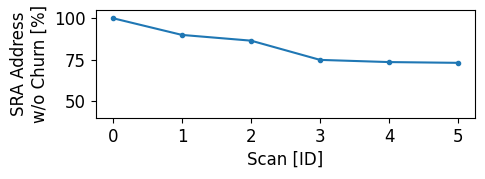

/home/service/artifacts-ipv6-sra-scanning/reports/figures/sra-churn.png


In [11]:
figsize = (7*0.7,2*0.7)
fig,ax = vh.fig_ax(figsize)

ax.plot([i for i in range(len(churn_columns))], churn_computation,marker='.')
#ax.plot([i for i in range(len(churn_columns))], churn_computation_rand,marker='.')

ax.set_xlabel('Scan [ID]')
ax.set_ylabel('SRA Address\nw/o Churn [%]')
ax.set_ylim(40,105)

plt.show()
vh.save_plot(fig,'sra-churn')

In [12]:
for i in range(1, 6):
    col = f"saddr_s{i}"
    df = df.with_columns(
        pl.when(pl.col(col).is_null())
          .then(pl.lit("Not seen"))
          .when(pl.col(col) == pl.col("saddr"))
          .then(pl.lit("Unchanged"))
          .otherwise(pl.lit("Changed"))
          .alias(f"{col}_status")
    )

In [22]:
status_cols = [f"saddr_s{i}_status" for i in range(1, 6)]

# Melt the dataframe to long format
df_long = df.unpivot(
    index=[],           # no id vars needed, just counts
    on=status_cols,
    variable_name="stage",
    value_name="status"
)

# Group by stage and status to get counts
df_plot = df_long.group_by(["stage", "status"]).agg(
    pl.len().alias("count")
).sort(["stage", "count"])

In [23]:
df_wide = df_plot.to_pandas().pivot(index='stage', columns='status', values='count')

df_pct = df_wide.div(df_wide.sum(axis=1), axis=0) * 100
df_pct = df_pct[['Unchanged','Not seen','Changed']]

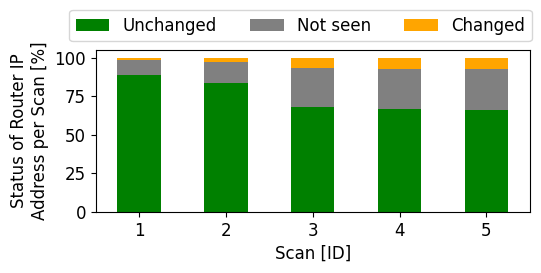

/home/service/artifacts-ipv6-sra-scanning/reports/figures/sra_stability_addr.png


In [30]:
figsize = (8*0.7,3*0.7)
fig,ax = vh.fig_ax(figsize)

df_pct.plot(
    kind='bar', 
    stacked=True,
    color=["green","gray","orange"],
    ax=ax)
ax.set_xlabel('Scan [ID]')
ax.set_ylabel('Status of Router IP\nAddress per Scan [%]')
ax.set_xticks([i for i in range(0,5)],[i for i in range(1,6)],rotation=0)
ax.set_yticks([0,25,50,75,100])
plt.legend(ncols=3,bbox_to_anchor=(-0.08,1.3),loc='upper left')
plt.show()
vh.save_plot(fig,'sra_stability_addr',autoclose=True)

In [16]:
df_pct

status,Unchanged,Not seen,Changed
stage,,,
saddr_s1_status,88.536497,10.079267,1.384235
saddr_s2_status,83.878596,13.534547,2.586857
saddr_s3_status,68.145866,25.130499,6.723635
saddr_s4_status,66.485968,26.447280,7.066753
saddr_s5_status,65.952234,26.908695,7.139070


In [17]:
for i in range(1, 6):
    col = f"saddr_s{i}"
    df_rand = df_rand.with_columns(
        pl.when(pl.col(col).is_null())
          .then(pl.lit("Not seen"))
          .when(pl.col(col) == pl.col("saddr"))
          .then(pl.lit("Unchanged"))
          .otherwise(pl.lit("Changed"))
          .alias(f"{col}_status")
    )

In [18]:
status_cols = [f"saddr_s{i}_status" for i in range(1, 6)]

# Melt the dataframe to long format
df_long = df_rand.unpivot(
    index=[],           # no id vars needed, just counts
    on=status_cols,
    variable_name="stage",
    value_name="status"
)

# Group by stage and status to get counts
df_plot = df_long.group_by(["stage", "status"]).agg(
    pl.len().alias("count")
).sort(["stage", "count"])

In [19]:
df_wide = df_plot.to_pandas().pivot(index='stage', columns='status', values='count')

df_pct = df_wide.div(df_wide.sum(axis=1), axis=0) * 100
df_pct = df_pct[['Unchanged','Not seen','Changed']]

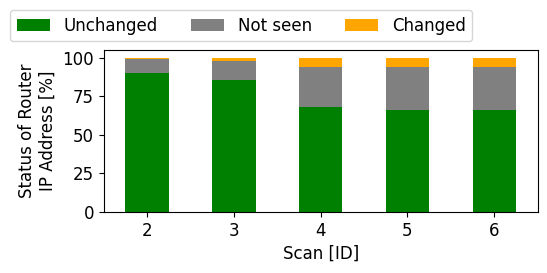

/home/service/artifacts-ipv6-sra-scanning/reports/figures/rand_stability_addr.png


In [20]:
figsize = (8*0.7,3*0.7)
fig,ax = vh.fig_ax(figsize)

df_pct.plot(
    kind='bar', 
    stacked=True,
    color=["green","gray","orange"],
    ax=ax)
ax.set_xlabel('Scan [ID]')
ax.set_ylabel('Status of Router\nIP Address [%]')
ax.set_xticks([i for i in range(0,5)],[i for i in range(2,7)],rotation=0)
ax.set_yticks([0,25,50,75,100])
plt.legend(ncols=3,bbox_to_anchor=(-0.235,1.3),loc='upper left')
plt.show()
vh.save_plot(fig,'rand_stability_addr',autoclose=True)

In [21]:
df_pct

status,Unchanged,Not seen,Changed
stage,,,
saddr_s1_status,90.189419,8.924219,0.886362
saddr_s2_status,85.322076,12.807591,1.870334
saddr_s3_status,68.079757,26.204207,5.716036
saddr_s4_status,66.237666,27.697163,6.065171
saddr_s5_status,66.271102,27.674589,6.054308
